In [35]:
import pandas as pd
import re
from collections import Counter
import numpy as np
import glob

import seaborn as sn
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.linalg import norm
import itertools

In [6]:
def preprocess_text(path):
    with open(path, "r") as f:
        text = f.read()
    text = re.sub(r"[.,-;!?–']", "", text)
    text = text.lower().split()
    length = len(text)
    cnt = Counter(text)
    for k,v in cnt.items():
        cnt[k] = v/length
    return cnt
    

def count_words_in_docs(paths):
    counteddocuments = []
    for path in paths:
        cnt = preprocess_text(path)
        counteddocuments.append(cnt)
    return counteddocuments
        

def z_standardization(word, document, counteddocuments):
    
    freqs_across_docs = [doc[word] for doc in counteddocuments]
    
    mue = np.mean(freqs_across_docs)
    sigma = np.std(freqs_across_docs)
    
    z = (document[word] - mue)/sigma
    
    return(z)

def create_doc_term_matrix(paths, n):
    counteddocuments = count_words_in_docs(paths)
    
    #n most frequent words in corpus
    mfw = Counter()
    for cnt in tqdm(counteddocuments, desc='accumulate total'):
        mfw += cnt
    nmfw = [tupel[0] for tupel in mfw.most_common(n)]
    
    
    df = pd.DataFrame(columns=[re.sub(r"\w+\/|\.txt", "", path) for path in paths], index=nmfw)
    
    for path in tqdm(paths, desc='build frequency matrix'):
        cnt = preprocess_text(path)  
        cnt_nmfw = []
        for w in nmfw:
            cnt_nmfw.append(cnt[w])
        df[re.sub(r"\w+\/|\.txt", "", path)] = cnt_nmfw
    
    #z-normalize across docs after building frequency matrix (performance)
    for w in tqdm(nmfw, desc='z-normalize'):
        freqs_across_docs = df.loc[w]
        mu = freqs_across_docs.mean()
        sigma = freqs_across_docs.std()
        df.loc[w] = (freqs_across_docs - mu) / sigma
    return(df)
    
    

In [7]:
paths = glob.glob("gerdracor_txt_1750_1920/*.txt")

In [38]:
df = create_doc_term_matrix(paths, 500)

z-normalize: 100%|██████████████████████████| 500/500 [00:00<00:00, 5221.07it/s]


In [39]:
df.head(5)

,laube-monaldeschi,schnitzer-der-zigeunerbaron,muellner-die-schuld,delpons-der-ahnherr,chezy-euryanthe,birch-pfeiffer-vatersorgen,angely-prinz-tu-ta-tu,goethe-die-wette,wildgans-in-ewigkeit-amen,nestroy-der-boese-geist-lumpazivagabundus,...,eichendorff-die-freier,moser-krieg-oder-frieden,arnim-jerusalem,schnitzler-literatur,grillparzer-weh-dem-der-luegt,brentano-ponce-de-leon,kotzebue-die-spanier-in-peru,grillparzer-ein-bruderzwist-in-habsburg,heine-william-ratcliff,vischer-faust
ich,-0.616108,-0.510765,-1.087459,-0.285371,-0.556118,0.448969,0.815001,-0.054033,-1.186291,0.919331,...,-0.024116,0.787937,0.064123,1.560904,0.407390,0.839455,-0.240314,-1.002415,0.215769,-1.448902
und,1.542190,1.316245,0.642935,-0.695765,-0.960799,-0.498872,0.157548,1.264509,-0.172283,-0.913776,...,-0.125981,-1.409869,-0.705224,-1.432222,1.058555,0.388988,0.018184,1.223522,2.499469,-0.339967
die,0.091881,0.082628,0.106995,-1.266169,0.017224,0.259094,-0.549757,0.787423,-0.265407,-0.624044,...,0.537886,-0.736882,0.440826,-0.897328,-0.879248,0.229469,-0.317517,1.328217,0.446110,0.479163
der,0.283546,0.432761,1.346868,-0.005065,0.725678,-0.004026,0.076988,-1.477368,0.413007,0.267884,...,0.250166,-1.003886,0.614395,-1.032940,-0.117379,-0.748635,0.143710,1.598674,0.513454,1.028935
sie,-0.494823,-1.008595,-0.693570,-0.614845,-0.898916,1.007120,-1.178552,1.348474,2.091188,-0.524533,...,0.511138,-0.241582,-0.584238,-0.648461,-0.737169,-0.225366,-1.000473,-0.893121,-0.968030,-0.976001


In [40]:
# Anton pairwise Cosine distance
pairwise_cosine_distance = pd.DataFrame(index=df.columns, columns=df.columns)
with tqdm(total=len(df.columns)**2) as pbar:
    for doc_a in df.columns:
        for doc_b in df.columns:
            vec_a = df[doc_a].values
            vec_b = df[doc_b].values
            pairwise_cosine_distance.loc[doc_a,doc_b] = (vec_a @ vec_b) / (norm(vec_a) * norm(vec_b))
            pbar.update(1)

100%|████████████████████████████████| 303601/303601 [00:10<00:00, 28734.71it/s]


In [43]:
# nur 50 mfw
df = create_doc_term_matrix(paths, 50)
# Anton pairwise Cosine distance
pairwise_cosine_distance = pd.DataFrame(index=df.columns, columns=df.columns)
with tqdm(total=len(df.columns)**2) as pbar:
    for doc_a in df.columns:
        for doc_b in df.columns:
            vec_a = df[doc_a].values
            vec_b = df[doc_b].values
            pairwise_cosine_distance.loc[doc_a,doc_b] = (vec_a @ vec_b) / (norm(vec_a) * norm(vec_b))
            pbar.update(1)
# ex: 10 closest vectors to goethe-iphigenie-auf-tauris
pairwise_cosine_distance.loc['goethe-iphigenie-auf-tauris'].sort_values(ascending=False).iloc[:10]

100%|████████████████████████████████| 303601/303601 [00:10<00:00, 29072.39it/s]


goethe-iphigenie-auf-tauris                1.0
brentano-die-gruendung-prags          0.763418
schiller-die-braut-von-messina        0.753469
gehe-jessonda                         0.747325
schiller-die-jungfrau-von-orleans     0.733576
richter-eumenides-duester             0.720244
schlegel-jon                          0.717075
grabbe-kaiser-friedrich-barbarossa    0.683776
uhland-ernst-herzog-von-schwaben      0.678249
immermann-merlin                      0.650491
Name: goethe-iphigenie-auf-tauris, dtype: object

In [41]:
# ex: 10 closest vectors to goethe-iphigenie-auf-tauris
pairwise_cosine_distance.loc['goethe-iphigenie-auf-tauris'].sort_values(ascending=False).iloc[:10]

goethe-iphigenie-auf-tauris               1.0
goethe-die-natuerliche-tochter       0.524541
schiller-die-braut-von-messina       0.501033
schlegel-jon                         0.488312
gehe-jessonda                        0.469966
goethe-torquato-tasso                0.455182
schiller-die-jungfrau-von-orleans    0.443631
brentano-die-gruendung-prags         0.429098
immermann-merlin                     0.421187
uhland-ernst-herzog-von-schwaben     0.407565
Name: goethe-iphigenie-auf-tauris, dtype: object

In [44]:
# noch mehr mfw (1000)
df = create_doc_term_matrix(paths, 1000)
# Anton pairwise Cosine distance
pairwise_cosine_distance = pd.DataFrame(index=df.columns, columns=df.columns)
with tqdm(total=len(df.columns)**2) as pbar:
    for doc_a in df.columns:
        for doc_b in df.columns:
            vec_a = df[doc_a].values
            vec_b = df[doc_b].values
            pairwise_cosine_distance.loc[doc_a,doc_b] = (vec_a @ vec_b) / (norm(vec_a) * norm(vec_b))
            pbar.update(1)
# ex: 10 closest vectors to goethe-iphigenie-auf-tauris
pairwise_cosine_distance.loc['goethe-iphigenie-auf-tauris'].sort_values(ascending=False).iloc[:10]

100%|████████████████████████████████| 303601/303601 [00:10<00:00, 28115.04it/s]


goethe-iphigenie-auf-tauris               1.0
goethe-die-natuerliche-tochter       0.494175
goethe-torquato-tasso                0.459392
schlegel-jon                         0.432296
schiller-die-braut-von-messina       0.423969
schiller-die-jungfrau-von-orleans    0.403481
gehe-jessonda                        0.357819
brentano-die-gruendung-prags         0.342564
kotzebue-der-schutzgeist             0.324612
guenderode-udohla                    0.317841
Name: goethe-iphigenie-auf-tauris, dtype: object

In [ ]:
# Agnes Implementierung der Distanzen

In [45]:

def manhattan(u,v):
    return sum([abs(u[i] - v[i]) for i in range(len(u))])

def euclidian(u,v):
    return sum([(u[i] - v[i])**2 for i in range(len(u))])**0.5

def cosine(u,v):
    zähler = sum([u[i] * v[i] for i in range(len(u))])
    nenner = (sum([num**2 for num in u])**0.5) * (sum([num**2 for num in v])**0.5) 
    return zähler/nenner

In [47]:
käthchen = df["kleist-das-kaethchen-von-heilbronn"].to_list()
krug = df["kleist-der-zerbrochene-krug"].to_list()
minna = df["lessing-minna-von-barnhelm"].to_list()

print("Distanzen für ausgewählte Beispiele")

print("Euklidische Distanz zwischen Käthchen, Minna: ", euclidian(käthchen, minna))
print("Euklidische Distanz zwischen Käthchen, Krug: ", euclidian(käthchen, krug), "\n")

print("Manhattan-Distanz zwischen Käthchen, Minna: ", manhattan(käthchen, minna))
print("Manhattan-Distanz zwischen Käthchen, Krug: ", manhattan(käthchen, krug), "\n")

print("Cosinus-Distanz zwischen Käthchen, Minna: ", cosine(käthchen, minna))
print("Cosinus-Distanz zwischen Käthchen, Krug: ", cosine(käthchen, krug))

Distanzen für ausgewählte Beispiele
Euklidische Distanz zwischen Käthchen, Minna:  35.53227098683561
Euklidische Distanz zwischen Käthchen, Krug:  35.00896086040633 

Manhattan-Distanz zwischen Käthchen, Minna:  785.5627048489041
Manhattan-Distanz zwischen Käthchen, Krug:  657.7428841472467 

Cosinus-Distanz zwischen Käthchen, Minna:  -0.09227499907263927
Cosinus-Distanz zwischen Käthchen, Krug:  0.30671923740886864


In [48]:
# Implementing Burrows Delta: Document-Document-Matrix

delta_dict = {doc: {} for doc in df.columns}
for doc in df.columns:
    for doc1 in df.columns:
        man = manhattan(df[doc].to_list(), df[doc1].to_list())
        delta_dict[doc][doc1] = man


In [49]:
delta_df = pd.DataFrame(delta_dict)

In [50]:
delta_df.loc['goethe-iphigenie-auf-tauris'].sort_values(ascending=True).iloc[:10]

goethe-iphigenie-auf-tauris                  0.000000
goethe-die-natuerliche-tochter             543.040693
schlegel-jon                               547.015217
goethe-torquato-tasso                      570.736157
schiller-die-braut-von-messina             575.797781
schiller-die-jungfrau-von-orleans          579.201736
brentano-die-gruendung-prags               583.649633
goethe-faust-der-tragoedie-zweiter-teil    591.125453
immermann-merlin                           607.545780
schiller-maria-stuart                      615.200038
Name: goethe-iphigenie-auf-tauris, dtype: float64

## Visualisierung

<AxesSubplot:>

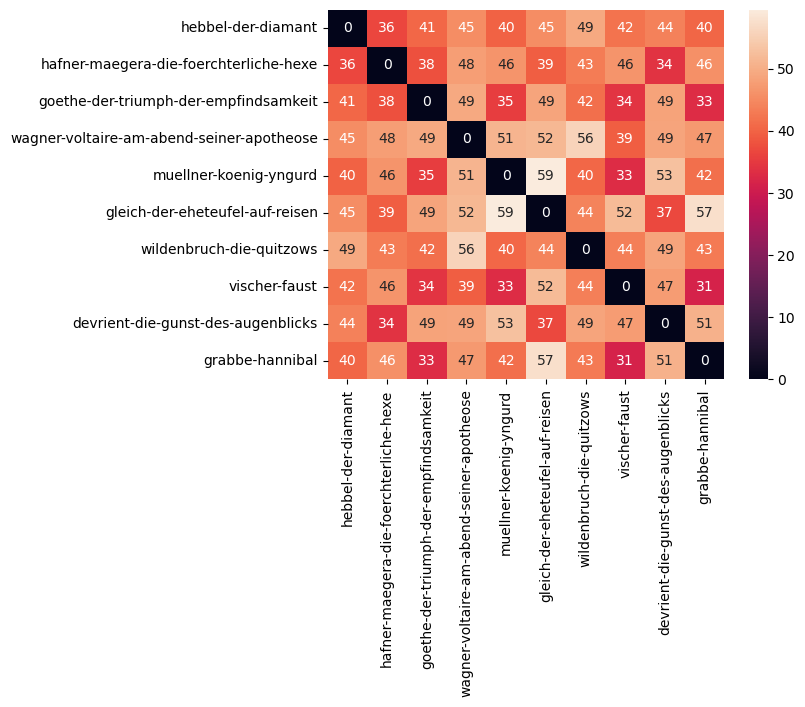

In [23]:
#Teil der Delta-Matrix als heatmap
delta_df_small = delta_df.sample(10)
delta_df_small = delta_df_small[delta_df_small.index.to_list()].copy()
plt.figure()
sn.heatmap(delta_df_small, annot=True)

# Plot: Verteilung ingroup vs outgroup similarity (Anton)


In [32]:
metadata = pd.read_csv("gerdracor-metadata_1750-1920.csv", sep=";", encoding="utf-8", index_col=0)
authors = metadata['firstAuthor'].unique()

In [36]:
pairwise_ingroup_distances = {}
pairwise_outgroup_distances = {}

for author in tqdm(authors):
    author_works = metadata[metadata['firstAuthor'] == author]['name']
    if len(author_works) < 8:
        continue
        
    outgroup = []
    for work in pairwise_cosine_distance.index:
        if work not in list(author_works):
            outgroup.append(work)
            
    outgroup_distances = []
    for out_work in outgroup:
        for in_work in author_works:
            outgroup_distances.append(pairwise_cosine_distance.loc[out_work,in_work])
            
    ingroup_distances = []
    # all (unsorted) combinations of two of the author's works
    for in_work1, in_work2 in itertools.combinations(author_works, 2):
        ingroup_distances.append(pairwise_cosine_distance.loc[in_work1,in_work2])
        
    pairwise_ingroup_distances[author] = ingroup_distances
    pairwise_outgroup_distances[author] = outgroup_distances

100%|████████████████████████████████████████| 213/213 [00:00<00:00, 380.99it/s]


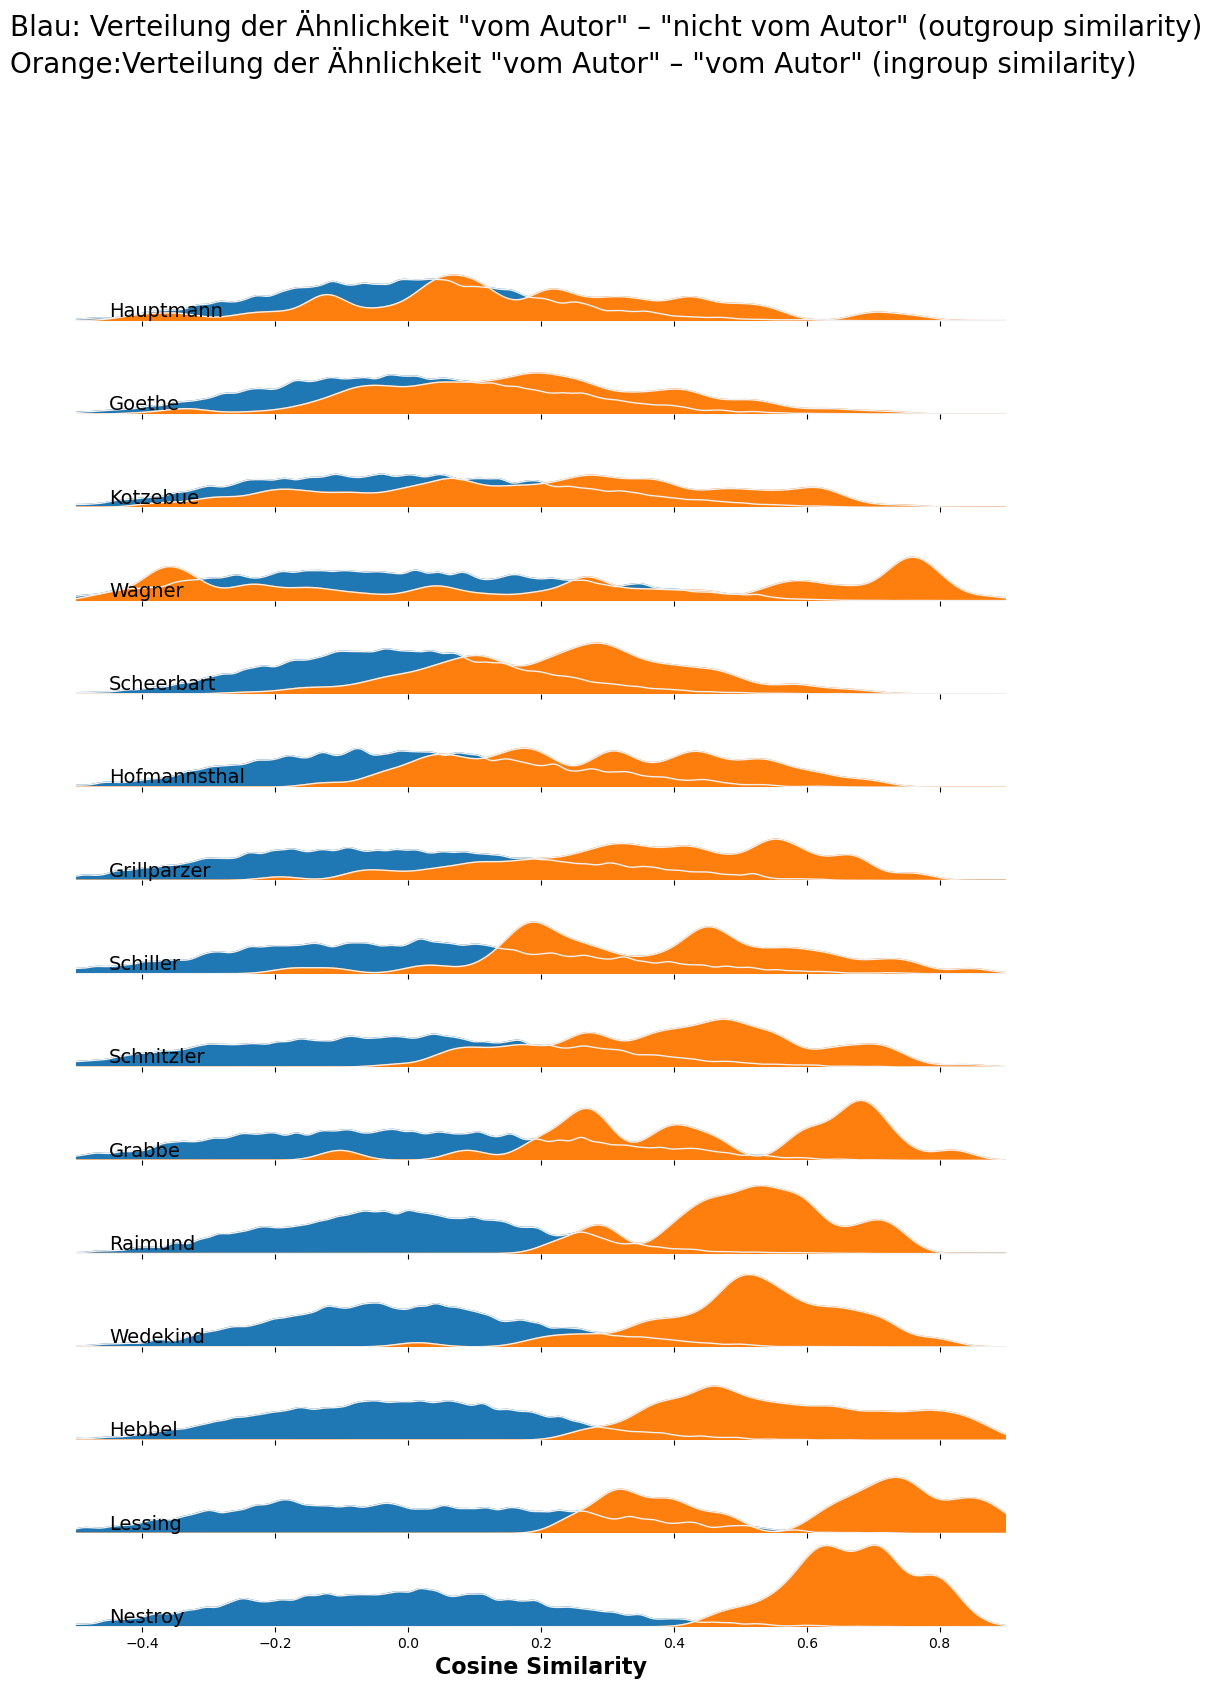

In [37]:
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity

plot_authors = list(pairwise_ingroup_distances.keys())
plot_authors = sorted(plot_authors, key=lambda a: np.array(pairwise_ingroup_distances[a]).mean())

gs = grid_spec.GridSpec(len(plot_authors),1)
fig = plt.figure(figsize=(12,len(plot_authors)*1.4))

i = 0

ax_objs = []
for author in plot_authors:
        
    ingroup_distances = pairwise_ingroup_distances[author]
    outgroup_distances = pairwise_outgroup_distances[author]
    
    
    x_d = np.linspace(-1,1, 1000)
        
    #outgroup dist
    x = np.array(outgroup_distances)

    kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color='tab:blue')
    
    #ingroup dist
    x = np.array(ingroup_distances)

    kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color='tab:orange')


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.5,0.9)
    ax_objs[-1].set_ylim(0,15)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_yticks([])
    
    
    if i < len(plot_authors)-1:
        ax_objs[-1].set_xticklabels([])
    else:
        ax_objs[-1].set_xlabel("Cosine Similarity", fontsize=16,fontweight="bold")

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.45,0.2,author,fontsize=14,ha="left")
    i += 1

gs.update(hspace=-0.7)
fig.text(0.07,0.85,'Blau: Verteilung der Ähnlichkeit "vom Autor" – "nicht vom Autor" (outgroup similarity)\nOrange:Verteilung der Ähnlichkeit "vom Autor" – "vom Autor" (ingroup similarity)',fontsize=20)
plt.show()